# Mentions Extraction for KBQA

Parsing question into entities and predicate mentions text spans.

bi-LSTM + CRF  
https://github.com/UKPLab/emnlp2017-bilstm-cnn-crf  
https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/  
https://github.com/SNUDerek/multiLSTM  

In [1]:
# setup
dataset_name = 'lcquad'
embeddings_choice = 'glove840B300d'

import numpy as np
# set seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import os
os.chdir('/mpqa/KBQA/src')

# load word frequencies
import pickle
#wfd = pickle.load(open("wfd.pkl", "rb"))

# make sure Keras is using the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# load pre-trained word embeddings
from pymagnitude import *
embeddings_path = "/mpqa/KBQA/data/embeddings/"
embeddings = {'glove840B300d': "glove.840B.300d.magnitude"}
vectors = Magnitude(embeddings_path + embeddings[embeddings_choice])

/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/tensorflow/pyth

In [2]:
# load lcquad span annotations
# wget https://raw.githubusercontent.com/AskNowQA/EARL/master/data/lcquad.json
import json
with open("../data/%s.json"%dataset_name, "r", encoding='utf-8') as file:
    qas = json.load(file)

# prepare data for entity and predicate mention extraction models training via sequence tagging
limit = 5000
from keras.preprocessing.text import text_to_word_sequence

questions = []
n_words_distr = []

e_spans = []
y_e = []
correct_entities_uris = []

p_spans = []
y_p = []
correct_predicates_uris = []

for q in qas[:limit]:
    # parse question
    question_o = q['question']
    words = text_to_word_sequence(question_o)
    n_words_distr.append(len(words))
    questions.append(words)

    # generate IO tags from mention spans
    entity_spans = [e['label'].lower().split() for e in q['entity mapping']]
    e_spans.append(entity_spans)
    y_e.append([1 if word in [entity for entity_span in entity_spans for entity in entity_span] else 0 for word in words])
    correct_entities_uris.append([e['uri'] for e in q['entity mapping']])
    
    predicate_spans = [e['label'].lower().split() for e in q['predicate mapping']]
    p_spans.append(predicate_spans)
    y_p.append([1 if word in [entity for entity_span in predicate_spans for entity in entity_span] else 0 for word in words])
    correct_predicates_uris.append([e['uri'] for e in q['predicate mapping']])

dataset_size = len(questions)
print("Loaded %d/%d %s questions"%(dataset_size, len(qas), dataset_name))

Loaded 5000/5000 lcquad questions


In [3]:
# show sample question
i = 1
question_o = qas[i]['question']
print(question_o)
print('\n')
print(e_spans[i])
print(y_e[i])
print(correct_entities_uris[i])
print('\n')
print(p_spans[i])
print(y_p[i])
print(correct_predicates_uris[i])

Was winston churchill the prime minister of Selwyn Lloyd?


[['selwyn', 'lloyd'], ['winston', 'churchill']]
[0, 1, 1, 0, 0, 0, 0, 1, 1]
['http://dbpedia.org/resource/Selwyn_Lloyd', 'http://dbpedia.org/resource/Winston_Churchill']


[['prime', 'minister']]
[0, 0, 0, 0, 1, 1, 0, 0, 0]
['http://dbpedia.org/ontology/primeMinister']


In [4]:
# load pre-trained embeddings for question words
words = list(set([word for q in questions for word in q]))
n_words = len(words)
print("Number of unique words %d"%len(words))
word2idx = {w: i + 1 for i, w in enumerate(words)}

# dataset parameters for training the model
max_len = max(n_words_distr)
print("Maximum question length in the dataset: %d"%max_len)
n_tags = 2

# prepare data and pad the max length with 0s
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w] for w in s] for s in questions]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# load embeddings into matrix
import math
word_embedding_matrix = np.zeros((n_words+1, vectors.dim))

n_oov = 0

for w in word2idx:
    # get the word vector from the embedding model
    if w in vectors:
        word_vector = vectors.query(w)
    # OOV word
    else:
        n_oov += 1
        word_vector = vectors.query('unk')
    word_embedding_matrix[word2idx[w]] = word_vector

# loaded vector # may be lower than total vocab due to w2v settings
print('%d OOV words'%n_oov)

model_settings = {'embeddings': word_embedding_matrix, 'word2idx': word2idx,
                  'max_len': max_len, 'n_words': n_words, 'n_tags': n_tags, 'emb_dim': vectors.dim}

# save model settings
import pickle as pkl
f = open('%s_%s.pkl'%(dataset_name, embeddings_choice), 'wb')
pkl.dump(model_settings, f, -1)
f.close()
print("Model settings saved.")

Number of unique words 7113
Maximum question length in the dataset: 25
1262 OOV words
Model settings saved.


In [5]:
# build biLSTM-CRF model for mention extraction
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.optimizers import Adam

def build_model(model_settings):
    # architecture
    input = Input(shape=(model_settings['max_len'],))
    model = Embedding(input_dim=model_settings['n_words']+1, output_dim=model_settings['emb_dim'],
                      weights=[model_settings['embeddings']],
                      input_length=model_settings['max_len'], mask_zero=True, trainable=False)(input)
    model = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.1))(model)  # variational biLSTM
    model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
    crf = CRF(model_settings['n_tags'])  # CRF layer
    out = crf(model)  # output
    model = Model(input, out)
    model.compile(optimizer=Adam(lr=0.0001), loss=crf.loss_function, metrics=[crf.accuracy])
    model.summary()
    return model

model = build_model(model_settings)

/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 300)           2134200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 100)           140400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 25, 2)             110       
Total params: 2,279,760
Trainable params: 145,560
Non-trainable params: 2,134,200
_________________________________________________________________


## Entity mentions

In [6]:
# train entity mention span model
y = y_e
modelname = 'entity_model'

# prepare data
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

# split dataset into training and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print("Training on %d samples testing on %d samples" % (len(X_train), len(X_test)))

Training on 4500 samples testing on 500 samples


In [7]:
# callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN, ModelCheckpoint
cb_redlr = ReduceLROnPlateau(monitor='val_crf_viterbi_accuracy', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
cb_early = EarlyStopping(monitor='val_crf_viterbi_accuracy', min_delta=0, patience=5, verbose=1)
cb_chkpt = ModelCheckpoint('../checkpoints/_'+modelname+'{epoch:02d}-{val_crf_viterbi_accuracy:.2f}.h5', verbose=1, save_best_only=True, save_weights_only=True, period=5)

callbacks_list=[cb_redlr, cb_early, cb_chkpt]

# start training
log = model.fit(X_train, np.array(y_train), batch_size=32, epochs=50,
                callbacks=callbacks_list,
                validation_split=0.1, verbose=1)

Train on 4050 samples, validate on 450 samples
Epoch 1/50
4050/4050 [==============================] - 20s 5ms/step - loss: 1.5506 - crf_viterbi_accuracy: 0.7547 - val_loss: 1.5037 - val_crf_viterbi_accuracy: 0.7878
Epoch 2/50
4050/4050 [==============================] - 17s 4ms/step - loss: 1.4194 - crf_viterbi_accuracy: 0.8177 - val_loss: 1.4055 - val_crf_viterbi_accuracy: 0.8423
Epoch 3/50
4050/4050 [==============================] - 17s 4ms/step - loss: 1.3383 - crf_viterbi_accuracy: 0.8635 - val_loss: 1.3387 - val_crf_viterbi_accuracy: 0.8729
Epoch 4/50
4050/4050 [==============================] - 17s 4ms/step - loss: 1.2947 - crf_viterbi_accuracy: 0.8874 - val_loss: 1.3110 - val_crf_viterbi_accuracy: 0.8872
Epoch 5/50
4050/4050 [==============================] - 17s 4ms/step - loss: 1.2767 - crf_viterbi_accuracy: 0.8937 - val_loss: 1.2978 - val_crf_viterbi_accuracy: 0.8942

Epoch 00005: val_loss improved from inf to 1.29779, saving model to ../checkpoints/_entity_model05-0.89.h5


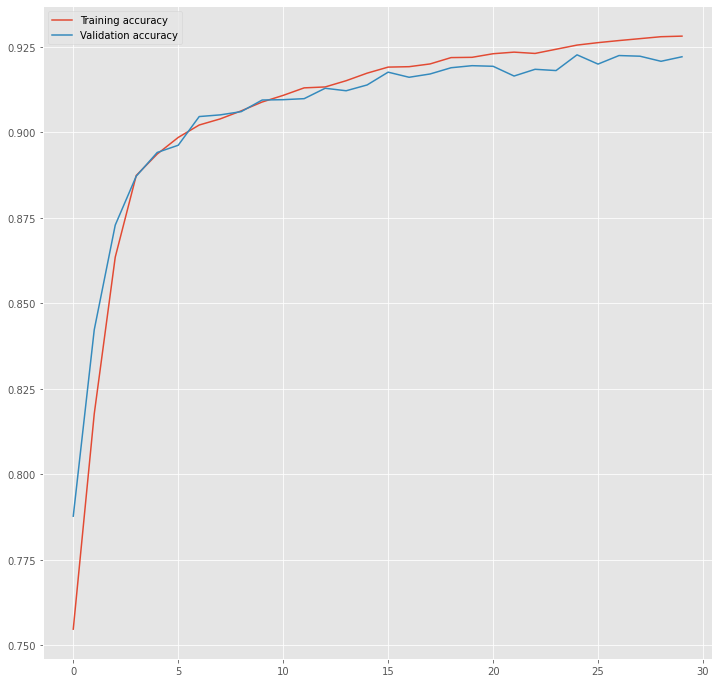

In [8]:
# plot accuracies
import pandas as pd
hist = pd.DataFrame(log.history)
# print(hist)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"], label='Training accuracy')
plt.plot(hist["val_crf_viterbi_accuracy"], label='Validation accuracy')
plt.legend()
plt.show()

In [9]:
# save model
from keras_contrib.utils import save_load_utils
with open('../models/' + modelname + '.json', 'w') as f:
    f.write(model.to_json())
# save weights
save_load_utils.save_all_weights(model, '../models/'+modelname+'.h5')

In [10]:
# load model settings
import pickle as pkl
with open('%s_%s.pkl'%(dataset_name, embeddings_choice), 'rb') as f:
    model_settings = pkl.load(f)
model = build_model(model_settings)

# load weights
model.load_weights('../models/'+modelname+'.h5')

# evaluate model on the test set
test_pred = model.predict(X_test, verbose=1)

idx2tag = {1: 'I', 0: 'O'}
pred_labels = [[idx2tag[np.argmax(p)] for p in pred_i] for pred_i in test_pred]
test_labels = [[idx2tag[np.argmax(p)] for p in pred_i] for pred_i in y_test]

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels, average='weighted')))
print("Precision-score: {:.1%}".format(precision_score(test_labels, pred_labels, average='weighted')))
print("Recall-score: {:.1%}".format(recall_score(test_labels, pred_labels, average='weighted')))

/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/mpqa/miniconda3/envs/kbqa/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 25, 300)           2134200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 25, 100)           140400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 25, 2)             110       
Total params: 2,279,760
Trainable params: 145,560
Non-trainable params: 2,134,200
_________________________________________________________________
500/500 [==============================] - 1s 2ms/step
F1-score: 69.2%
Precision-score: 70.4%
Recall-score: 68.0%


In [11]:
# show sample test prediction
# i = 1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], t, pred))

Word           ||True ||Pred
what           :     0 0
are            :     0 0
some           :     0 0
musical        :     0 0
artists        :     0 0
associated     :     0 0
with           :     0 0
the            :     0 0
ones           :     0 0
signed         :     0 0
up             :     0 0
with           :     0 0
emi            :     1 1


## Predicate mentions

In [12]:
# train entity mention span model
y = y_p
modelname = 'predicate_model'

# prepare data
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

# split dataset into training and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print("Training on %d samples testing on %d samples" % (len(X_train), len(X_test)))

Training on 4500 samples testing on 500 samples


In [13]:
# callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN, ModelCheckpoint
cb_redlr = ReduceLROnPlateau(monitor='val_crf_viterbi_accuracy', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
cb_early = EarlyStopping(monitor='val_crf_viterbi_accuracy', min_delta=0, patience=5, verbose=1)
cb_chkpt = ModelCheckpoint('../checkpoints/_'+modelname+'{epoch:02d}-{val_crf_viterbi_accuracy:.2f}.h5', verbose=1, save_best_only=True, save_weights_only=True, period=5)

callbacks_list=[cb_redlr, cb_early, cb_chkpt]

# start training
log = model.fit(X_train, np.array(y_train), batch_size=32, epochs=50,
                callbacks=callbacks_list,
                validation_split=0.1, verbose=1)

Train on 4050 samples, validate on 450 samples
Epoch 1/50
4050/4050 [==============================] - 20s 5ms/step - loss: 1.9275 - crf_viterbi_accuracy: 0.6716 - val_loss: 1.6588 - val_crf_viterbi_accuracy: 0.7395
Epoch 2/50
4050/4050 [==============================] - 17s 4ms/step - loss: 1.6104 - crf_viterbi_accuracy: 0.7698 - val_loss: 1.5009 - val_crf_viterbi_accuracy: 0.7851
Epoch 3/50
4050/4050 [==============================] - 18s 4ms/step - loss: 1.5024 - crf_viterbi_accuracy: 0.8010 - val_loss: 1.4344 - val_crf_viterbi_accuracy: 0.8096
Epoch 4/50
4050/4050 [==============================] - 18s 4ms/step - loss: 1.4505 - crf_viterbi_accuracy: 0.8208 - val_loss: 1.3955 - val_crf_viterbi_accuracy: 0.8255
Epoch 5/50
4050/4050 [==============================] - 17s 4ms/step - loss: 1.4192 - crf_viterbi_accuracy: 0.8371 - val_loss: 1.3712 - val_crf_viterbi_accuracy: 0.8421

Epoch 00005: val_loss improved from inf to 1.37120, saving model to ../checkpoints/_predicate_model05-0.84.

4050/4050 [==============================] - 19s 5ms/step - loss: 1.2909 - crf_viterbi_accuracy: 0.9006 - val_loss: 1.2666 - val_crf_viterbi_accuracy: 0.9000
Epoch 44/50
4050/4050 [==============================] - 19s 5ms/step - loss: 1.2898 - crf_viterbi_accuracy: 0.9016 - val_loss: 1.2667 - val_crf_viterbi_accuracy: 0.8983
Epoch 45/50
4050/4050 [==============================] - 19s 5ms/step - loss: 1.2888 - crf_viterbi_accuracy: 0.9022 - val_loss: 1.2656 - val_crf_viterbi_accuracy: 0.9006

Epoch 00045: val_loss improved from 1.26813 to 1.26556, saving model to ../checkpoints/_predicate_model45-0.90.h5
Epoch 46/50
4050/4050 [==============================] - 19s 5ms/step - loss: 1.2884 - crf_viterbi_accuracy: 0.9034 - val_loss: 1.2656 - val_crf_viterbi_accuracy: 0.8998
Epoch 47/50
4050/4050 [==============================] - 19s 5ms/step - loss: 1.2873 - crf_viterbi_accuracy: 0.9030 - val_loss: 1.2644 - val_crf_viterbi_accuracy: 0.9012
Epoch 48/50
4050/4050 [========================

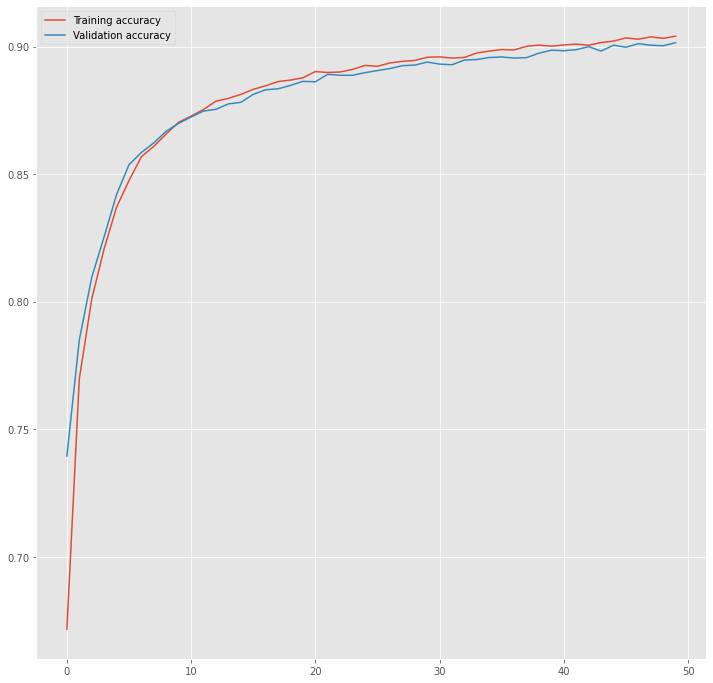

In [14]:
# plot accuracies
import pandas as pd
hist = pd.DataFrame(log.history)
# print(hist)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"], label='Training accuracy')
plt.plot(hist["val_crf_viterbi_accuracy"], label='Validation accuracy')
plt.legend()
plt.show()

In [15]:
# save model
from keras_contrib.utils import save_load_utils
with open('../models/' + modelname + '.json', 'w') as f:
    f.write(model.to_json())
# save weights
save_load_utils.save_all_weights(model, '../models/'+modelname+'.h5')

# load weights
model.load_weights('../models/'+modelname+'.h5')

# evaluate model on the test set
test_pred = model.predict(X_test, verbose=1)

idx2tag = {1: 'I', 0: 'O'}
pred_labels = [[idx2tag[np.argmax(p)] for p in pred_i] for pred_i in test_pred]
test_labels = [[idx2tag[np.argmax(p)] for p in pred_i] for pred_i in y_test]

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels, average='weighted')))

500/500 [==============================] - 1s 2ms/step
F1-score: 59.6%


In [16]:
# show sample test prediction
i = 1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], t, pred))

Word           ||True ||Pred
who            :     0 0
are            :     0 0
the            :     1 0
judges         :     1 1
of             :     0 0
the            :     1 0
television     :     1 1
show           :     1 0
whose          :     0 0
anchor         :     0 1
is             :     0 0
josh           :     0 0
groban         :     0 0
